# Lecture : Graph Generation Models

## Lab 02 : Variational autoencoders (VAE) for QM9 molecular graphs

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd 
    !pip install rdkit==2023.09.6 # Install RDKit
    

In [2]:
# Libraries
import os
import time
from rdkit import Chem
from rdkit import RDLogger; RDLogger.DisableLog('rdApp.*')
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
import sys; sys.path.insert(0, 'lib/')
from lib.molecules import Dictionary, Molecule, from_pymol_to_smile

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


/home/bcjr1997/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


2.0.1+cu118
NVIDIA GeForce RTX 4090 Laptop GPU
cuda:0


## Loading molecular datasets (PyTorch format)

Loading data...
dataset/QM9_1.4k_pytorch/
Time: 0.5322558879852295
num train data : 1000
atom_dict.idx2word : ['N', 'C', 'O', 'F', 'N H3 +', 'O -', 'C H1 -', 'N +', 'N -']
atom_dict.word2idx : {'N': 0, 'C': 1, 'O': 2, 'F': 3, 'N H3 +': 4, 'O -': 5, 'C H1 -': 6, 'N +': 7, 'N -': 8}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
9 4
train[idx].atom_type : tensor([1, 1, 2, 1, 1, 1, 1])
train[idx].atom_type_pe : tensor([0, 1, 0, 2, 3, 4, 5])
train[idx].bond_type : tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 1, 0]])
train[idx].bag_of_atoms : tensor([0, 6, 1, 0, 0, 0, 0, 0, 0])
train[idx].smile:  CC(O)C1CC1C


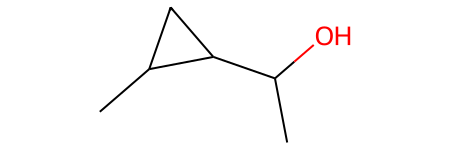

In [3]:
print('Loading data...') 
start = time.time()

data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"test_pytorch.pkl","rb") as f:
    test=pickle.load(f)
with open(data_folder_pytorch+"val_pytorch.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    train=pickle.load(f)
print('Time:',time.time()-start)

print('num train data :',len(train)) 

print('atom_dict.idx2word :',atom_dict.idx2word)
print('atom_dict.word2idx :',atom_dict.word2idx)
print('bond_dict.idx2word :',bond_dict.idx2word)
print('bond_dict.word2idx :',bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 45
print('train[idx].atom_type :',train[idx].atom_type)
print('train[idx].atom_type_pe :',train[idx].atom_type_pe)
print('train[idx].bond_type :',train[idx].bond_type)
print('train[idx].bag_of_atoms :',train[idx].bag_of_atoms)
print('train[idx].smile: ',train[idx].smile)
mol = Chem.MolFromSmiles(train[idx].smile)
mol


## Print dataset statistics

In [4]:
# Organize data into group of of molecules of fixed sized
# Example: train[9] is a list containing all the molecules of size 9  
def group_molecules_per_size(dataset):
    mydict={}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)]=[]
        mydict[len(mol)].append(mol)
    return mydict
test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)
print(len(train_group[8])) # QM9

# largest size of molecule in the trainset
max_mol_sz = max(list( train_group.keys()))
print('Max num atoms = ', max_mol_sz)

# print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try: 
            print('number of molecule of size {}: \t {}'.format(nb_atom, len(data[nb_atom])))
        except:
            pass
print('Train'); print_distribution(train_group)
print('Val'); print_distribution(val_group)
print('Test'); print_distribution(test_group)


136
Max num atoms =  9
Train
number of molecule of size 4: 	 1
number of molecule of size 5: 	 1
number of molecule of size 6: 	 7
number of molecule of size 7: 	 24
number of molecule of size 8: 	 136
number of molecule of size 9: 	 831
Val
number of molecule of size 7: 	 6
number of molecule of size 8: 	 28
number of molecule of size 9: 	 166
Test
number of molecule of size 6: 	 1
number of molecule of size 7: 	 3
number of molecule of size 8: 	 37
number of molecule of size 9: 	 159


## Generate batch of pytorch molecules of same size

In [5]:
# A class to help drawing batches of molecules with the same size
class MoleculeSampler:
    def __init__(self, organized_dataset, bs , shuffle=True):  
        self.bs = bs
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.counter = { sz: 0   for sz in organized_dataset }
        if shuffle:
            self.order = { sz: np.random.permutation(num)  for sz , num in self.num_mol.items() }
        else:
            self.order = { sz: np.arange(num)  for sz , num in self.num_mol.items() } 

    def compute_num_batches_remaining(self):
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol} 

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum( num_batches.values() ) == 0

    def draw_batch_of_molecules(self, sz):  
        num_batches = self.compute_num_batches_remaining()
        if (self.num_mol[sz] - self.counter[sz])/self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz]//self.bs) * self.bs
        #print('sz, bs',sz, bs)
        indices = self.order[sz][ self.counter[sz] : self.counter[sz] + bs]
        self.counter[sz] += bs 
        return indices

# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
while(not sampler.is_empty()):
    num_batches_remaining = sampler.compute_num_batches_remaining()
    print('num_batches_remaining :',num_batches_remaining)
    sz = sampler.choose_molecule_size()
    print('sz :',sz)
    indices = sampler.draw_batch_of_molecules(sz) 
    print('indices :',len(indices),indices)
    minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] )
    print('minibatch_node :',minibatch_node.size())
    minibatch_pe  = torch.stack( [ train_group[sz][i].atom_type_pe  for i in indices] )
    print('minibatch_pe :',minibatch_pe.size())
    minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] )
    print('minibatch_edge :',minibatch_edge.size())
    minibatch_boa = torch.stack( [ train_group[sz][i].bag_of_atoms for i in indices] )
    print('minibatch_boa :',minibatch_boa.size())
    break
    print('---------------------------------------')


sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 9
indices : 50 [375 143 612 355 485 261 632 629  40 709 491 329 222 249 310 170 759 217
 320 748 812 603 800 577 377  25 788 209  89  64 229 824  36  95 755 487
 732 131 737 651 746 644 129 401 560 674 589 369 415  86]
minibatch_node : torch.Size([50, 9])
minibatch_pe : torch.Size([50, 9])
minibatch_edge : torch.Size([50, 9, 9])
minibatch_boa : torch.Size([50, 9])


## Sample molecule size

In [6]:
# A class to sample a molecule size w.r.t. the train distribution
class sample_molecule_size:
    def __init__(self, organized_dataset):  
        self.num_mol =  { sz: len(list_of_mol)  for sz , list_of_mol in organized_dataset.items() }
        self.num_batches_remaining = { sz:  self.num_mol[sz]  for sz in self.num_mol } 
    def choose_molecule_size(self):
        num_batches = self.num_batches_remaining
        possible_sizes =  np.array( list( num_batches.keys()) )
        prob           =  np.array( list( num_batches.values() )   ) 
        prob =  prob / prob.sum()
        sz   = np.random.choice(  possible_sizes , p=prob )
        return sz
        
sampler_size = sample_molecule_size(train_group)
print('sampler_size.num_mol :',sampler_size.num_mol)
sz = sampler_size.choose_molecule_size()
print('sz :',sz)


sampler_size.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
sz : 9


# VAE [1] with Graph Transformers [2]

[1] Kingma, Welling, Auto-Encoding Variational Bayes, 2013, https://arxiv.org/pdf/1312.6114   
[2] Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020, https://arxiv.org/pdf/2012.09699.pdf  


In [7]:
# Global constants
dz = 32 # number of dimensions for the compressed representation
num_heads = 8 # number of heads in the transformer layer
d = 16 * num_heads # number of hidden dimensions
num_layers_encoder = 4 # number of transformer encoder layers
num_layers_decoder = 4 # number of transformer decoder layers
drop = 0.0 # dropout value
bs = 25 # batch size

print('dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs : ', \
      dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs)

# Warmup 
num_mol_size = 20
num_warmup = 2 * max( num_mol_size, len(train) // bs ) # 4 epochs * max( num_mol_size=20, num_mol/batch_size)
print('num_warmup :',num_warmup)


dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs :  32 8 128 4 4 0.0 25
num_warmup : 80


# Question 1 : Code the Graph Transformer with edge features

Hints: 
- The attention calculation involves edge features in an element-wise way, i.e., $q_i \odot e_{ij} \odot k_j$.
- The update formula on edge feature is similar to the update on node feature.
  

In [8]:
# Define VAE architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
    def forward(self, x, e):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E              # [bs, n, n, d_head]
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)            # [bs, n, n]
        Att = self.drop_att(Att)                   # [bs, n, n]
        x = Att @ V                  # [bs, n, d_head]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x, e                  # [bs, n, d_head], [bs, n, n, d_head]

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)
    def forward(self, x, e):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        x_MHA = []
        e_MHA = []    
        for head in self.heads:
            x_HA, e_HA = head(x,e)            # [bs, n, d_head], [bs, n, n, d_head]
            x_MHA.append(x_HA)
            e_MHA.append(e_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)                    # [bs, n, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x, e                           # [bs, n, d], [bs, n, n, d]

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNe = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.drop_e_mlp = nn.Dropout(drop)
    def forward(self, x, e):
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        x = self.LNx(x)                 # [bs, n, d]
        e = self.LNe(e)                 # [bs, n, n, d]
        x_MHA, e_MHA = self.MHA(x, e)   # [bs, n, d], [bs, n, n, d]
        x = x + x_MHA                   # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        e = e + e_MHA                   # [bs, n, n, d]
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)          # [bs, n, n, d]
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return x, e                     # [bs, n, d], [bs, n, n, d]

def sym_tensor(x):
    x = x.permute(0,3,1,2) # [bs, d, n, n]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0,2,3,1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

# Question 2: Implement the VAE architecture for molecule data

Hints:
- Guarantee the matrix symmetry, i.e. $E=E^T$, whenever dealing with edge-based matrices.
- The vector `mol_token` represents the whole molecule. It is computed by averaging the node embeddings after the encoding process. Edge embeddings solely participate in the graph Transformer calculation.
  

In [9]:
class VAE(nn.Module): 
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(max_mol_sz, d)
        self.atom_emb = nn.Embedding(num_atom_type, d)
        self.bond_emb = nn.Embedding(num_bond_type, d)
        self.gt_enc_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_encoder)] )
        self.gt_dec_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_decoder)] )
        self.linear_q_mu     = nn.Linear(d, dz)
        self.linear_q_logvar = nn.Linear(d, dz)
        self.linear_p = nn.Linear(dz, d)
        self.ln_x_final = nn.LayerNorm(d)  
        self.linear_x_final = nn.Linear(d, num_atom_type)
        self.ln_e_final = nn.LayerNorm(d)  
        self.linear_e_final = nn.Linear(d, num_bond_type)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_e_emb = nn.Dropout(drop)
        self.drop_p_emb = nn.Dropout(drop)
    def forward(self, x, e, train=True, num_gen=1, num_atom=9):
        
        # encoder
        if train: # training phase
            # input layer
            x = self.atom_emb(x)                   # [bs, n, d]
            bs2 = x.size(0); n = x.size(1)
            pe_x = torch.arange(0,n).to(device).repeat(bs2,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                            # [bs, n, d] 
            e = self.bond_emb(e)                   # [bs, n, n, d]
            e = sym_tensor(e)                      # [bs, n, n, d]
            x = self.drop_x_emb(x)                 # [bs, n, d]
            e = self.drop_e_emb(e)                 # [bs, n, n, d]        
            # GT layers   
            ###############################################
            # Get the distribution, including mean and logvar vectors
            # Sample `z` from the distribution via re-parameterization
            # YOUR CODE STARTS
            ###############################################
            # VAE Gaussian
            for layer in self.gt_enc_layers:
                x, e = layer(x, e)
                e = sym_tensor(e)
            mol_token = x.mean(1)
            q_mu = self.linear_q_mu(mol_token) # [bs, dz]
            q_logvar = self.linear_q_logvar(mol_token) # [bs, dz]
            q_std = torch.exp(0.5 * q_logvar)
            eps = torch.randn_like(q_std) 
            z = q_mu + eps * q_std # [bs, dz]
            ###############################################
            # YOUR CODE ENDS
            ###############################################
            bs_dec = bs; n = x.size(1) 
        else: # generation phase
            bs_dec = num_gen; n = num_atom
            pe_x = torch.arange(0,n).to(device).repeat(bs_dec,1) # [bs, n] 
            pe_x = self.pe_x(pe_x)                               # [bs, n, d] 
            z = torch.Tensor(bs_dec, dz).normal_(mean=0.0, std=1.0).to(device) # [b, dz]
            q_mu, q_logvar = _, _
            
        # decoder
        # input layer
        z = self.linear_p(z)             # [bs, d]  
        x = z.unsqueeze(1).repeat(1,n,1) # [bs, 1, d] => [bs, n, d]
        x = x + pe_x                     # [bs, n, d]
        e = z.unsqueeze(1).unsqueeze(2).repeat(1,n,n,1) # [bs, 1, 1, d] => [bs, n, n, d] 
        e = sym_tensor(e)                # [bs, n, n, d] 
        e = e + pe_x.unsqueeze(1) + pe_x.unsqueeze(2)       # [bs, n, n, d] 
        e = sym_tensor(e)                # [bs, n, n, d] 
        ###############################################
        # Code decoding process
        # YOUR CODE STARTS
        ###############################################
        # GT layers
        
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output
        x = self.ln_x_final(x)     # [bs, n, d]
        x = self.linear_x_final(x) # [bs, n, num_atom_type]
        e = self.ln_e_final(e)     # [bs, n, n, d] 
        e = self.linear_e_final(e) # [bs, n, n, num_bond_type] 

        return x, e, q_mu, q_logvar

# Question 3: Implement the training loss of VAE

Hints: 
- Since both atom and bond use discrete features representing their classes, the fidelity loss is cross entropy loss. Use [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
  

In [10]:
try:
    del net
    torch.cuda.empty_cache()
except:
  print("Firt run")

# Instantiate the network
net = VAE()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz) 
#print('indices :',len(indices),indices)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())

batch_x_pred, batch_e_pred, q_mu, q_logvar = net(batch_x0, batch_e0) # [bs, n], [bs, n, n]
print('batch_x_pred',batch_x_pred.size())
print('batch_e_pred',batch_e_pred.size())

bs2 = batch_x_pred.size(0)
###############################################
# YOUR CODE STARTS
###############################################
loss_data = torch.nn.CrossEntropyLoss()(batch_x_pred.view(bs2*sz,num_atom_type), batch_x0.view(bs2*sz))
loss_data = loss_data + torch.nn.CrossEntropyLoss()(batch_e_pred.view(bs2*sz*sz,num_bond_type), batch_e0.view(bs2*sz*sz))
###############################################
# YOUR CODE ENDS
###############################################
loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
loss_VAE = 1* loss_data + loss_KL
loss = loss_VAE
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
optimizer.step()

# generate new data
with torch.no_grad():
    num_data = 4; num_atom = 9
    batch_x_gen, batch_e_gen, _, _  = net(0, 0, False, num_data, num_atom) # [num_data, n]
    print('batch_x_gen',batch_x_gen.size())
    print('batch_e_gen',batch_e_gen.size()) 


Firt run
Number of parameters: 3189837 (3.19 million)
sampler.num_mol : {9: 831, 8: 136, 7: 24, 6: 7, 5: 1, 4: 1}
num_batches_remaining : {9: 17, 8: 3, 7: 1, 6: 1, 5: 1, 4: 1}
sz : 4
minibatch_node : torch.Size([1, 4])
minibatch_edge : torch.Size([1, 4, 4])
batch_x_pred torch.Size([1, 4, 9])
batch_e_pred torch.Size([1, 4, 4, 4])
batch_x_gen torch.Size([4, 9, 9])
batch_e_gen torch.Size([4, 9, 9, 4])


In [11]:
# Training loop
del net
net = VAE()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=5, verbose=True) # tracker scheduler

# Number of mini-batches per epoch
nb_epochs = 1000
num_warmup_batch = 0
print('dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs : ', dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs)
print('num_warmup, nb_epochs :',num_warmup, nb_epochs)

# Run training epochs
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0
    
    net.train()

    bs = 50
    sampler = MoleculeSampler(train_group, bs)
    while(not sampler.is_empty()):

        num_batches_remaining = sampler.compute_num_batches_remaining()
        sz = sampler.choose_molecule_size()
        indices = sampler.draw_batch_of_molecules(sz) 
        batch_x0 = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        batch_e0 = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        batch_x_pred, batch_e_pred, q_mu, q_logvar = net(batch_x0, batch_e0) # [bs, n], [bs, n, n]
        bs2 = batch_x_pred.size(0)
        loss_data = torch.nn.CrossEntropyLoss()(batch_x_pred.view(bs2*sz,num_atom_type), batch_x0.view(bs2*sz))
        loss_data = loss_data + torch.nn.CrossEntropyLoss()(batch_e_pred.view(bs2*sz*sz,num_bond_type), batch_e0.view(bs2*sz*sz))
        loss_KL = -0.5* torch.mean( 1.0 + q_logvar - q_mu.pow(2.0) - q_logvar.exp() )
        loss_VAE = 2.5 * loss_data + loss_KL
        loss = loss_VAE

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25) # grad_norm_clip=1.0
        optimizer.step()

        # Warmup scheduler for transformer layers
        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() 
        num_warmup_batch += 1

        # Compute stats
        running_loss += loss.detach().item()
        num_batches += 1

    # Average stats
    mean_loss = running_loss/num_batches
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_loss) # tracker scheduler defined w.r.t. loss value
        num_warmup_batch += 1
    elapsed = (time.time()-start)/60
    if not epoch%5:
        print('epoch= %d \t time= %.4f min \t lr= %.7f \t loss= %.4f' % (epoch, elapsed, optimizer.param_groups[0]['lr'],mean_loss) )
        
    # Intermediate result   
    # TODO
    
    # Check lr value  
    if optimizer.param_groups[0]['lr'] < 10**-5:
      print("\n lr is equal to min lr -- training stopped\n")
      break

    

Number of parameters: 3189837 (3.19 million)
dz, num_heads, d, num_layers_encoder, num_layers_decoder, drop, bs :  32 8 128 4 4 0.0 50
num_warmup, nb_epochs : 80 1000
epoch= 0 	 time= 0.0554 min 	 lr= 0.0000937 	 loss= 8.3657
epoch= 5 	 time= 0.2497 min 	 lr= 0.0003000 	 loss= 3.7929
epoch= 10 	 time= 0.4372 min 	 lr= 0.0003000 	 loss= 3.5709
epoch= 15 	 time= 0.6165 min 	 lr= 0.0003000 	 loss= 3.5249
epoch= 20 	 time= 0.8309 min 	 lr= 0.0003000 	 loss= 3.4525
epoch= 25 	 time= 1.0187 min 	 lr= 0.0003000 	 loss= 3.4136
epoch= 30 	 time= 1.2241 min 	 lr= 0.0003000 	 loss= 3.4078
epoch= 35 	 time= 1.4324 min 	 lr= 0.0003000 	 loss= 3.3878
epoch= 40 	 time= 1.6266 min 	 lr= 0.0003000 	 loss= 3.3569
epoch= 45 	 time= 1.8485 min 	 lr= 0.0003000 	 loss= 3.3528
epoch= 50 	 time= 2.0515 min 	 lr= 0.0003000 	 loss= 3.3303
epoch= 55 	 time= 2.2746 min 	 lr= 0.0003000 	 loss= 3.3131
epoch= 60 	 time= 2.4748 min 	 lr= 0.0003000 	 loss= 3.3112
epoch= 65 	 time= 2.6903 min 	 lr= 0.0003000 	 loss= 3.

KeyboardInterrupt: 

## Compute percentage of valid molecules

In [12]:
# compute percentage of valid molecules
def compute_perc_valid_molecules(net, sampler_size, num_gen_mol=1000, num_generated_mols_per_batch=100):
    num_atom = 9 # QM9
    num_batches = num_gen_mol // num_generated_mols_per_batch 
    num_valid_mol = 0
    list_valid_mol = []
    list_mol = []
    start = time.time()
    for idx in range(num_batches):
        net.eval()
        with torch.no_grad():  
            num_atom_sampled = sampler_size.choose_molecule_size() # sample the molecule size
            num_atom_sampled = num_atom # same size
            batch_x_0, batch_e_0, _, _  = net(0, 0, False, num_generated_mols_per_batch, num_atom_sampled) # [bs, n, num_atom_type], [bs, n, n, num_bond_type]
            batch_x_0 = torch.max(batch_x_0,dim=2)[1]  # [bs, n] 
            batch_e_0 = torch.max(batch_e_0,dim=3)[1]  # [bs, n, n]
            x_hat = batch_x_0.detach().to('cpu')
            e_hat = batch_e_0.detach().to('cpu')
            for x,e in zip(x_hat,e_hat):
                pymol = Molecule(num_atom_sampled, num_atom_type)
                pymol.atom_type = x
                pymol.bond_type = e
                smile = from_pymol_to_smile(pymol, atom_dict, bond_dict)
                list_mol.append(smile)
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    list_valid_mol.append(smile)
                    num_valid_mol += 1
    perc_valid_molecules = 100*num_valid_mol/num_gen_mol
    line = '\t num_gen_mol= ' + str(num_gen_mol) + '   time(min)= ' + str((time.time()-start)/60)[:5] + '   perc valid molecules= ' + str(perc_valid_molecules)[:6]
    return perc_valid_molecules, list_mol, line, list_valid_mol

perc_valid_mol, list_mol, line, list_valid_mol = compute_perc_valid_molecules(net, sampler_size)
print('percentage of valid molecules')
print(line)
print(list_valid_mol[:10])

 

percentage of valid molecules
	 num_gen_mol= 1000   time(min)= 0.004   perc valid molecules= 98.9
['NCCCNNNNN', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCO', 'CCCCCCCCO']


## Plot a few molecules

tensor([488,  51, 479, 544, 553, 780,  83, 135, 239, 403, 496,  39, 219, 175,
         93, 942])


<Figure size 1200x800 with 0 Axes>

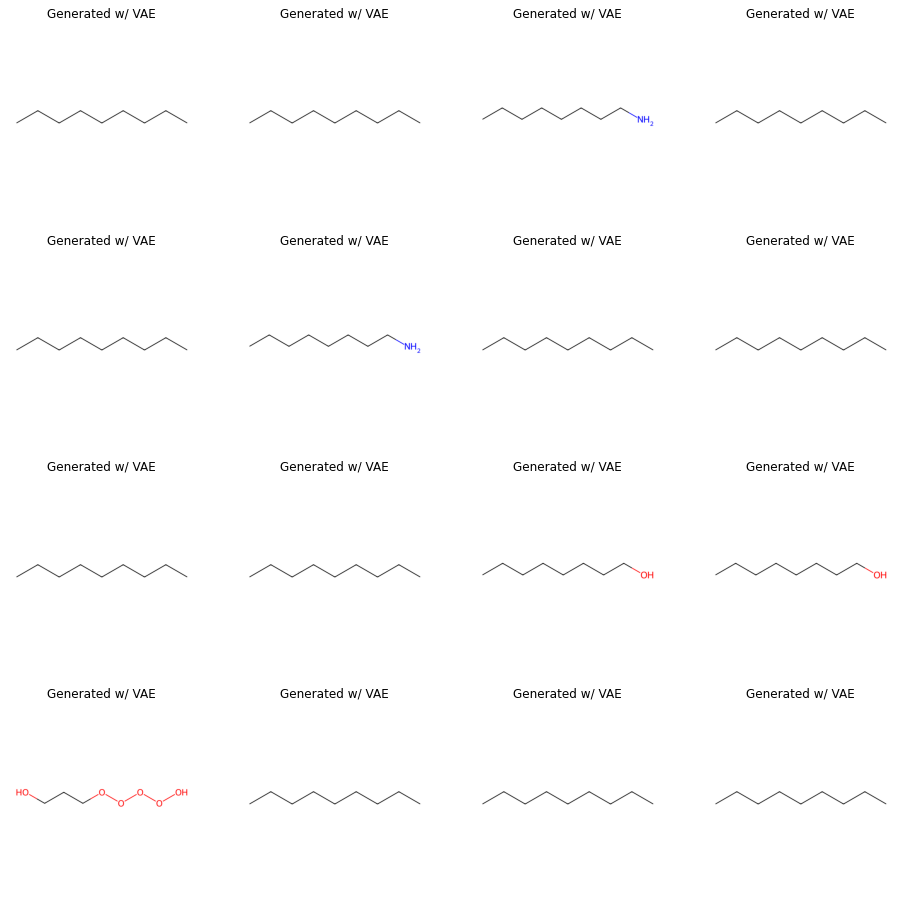

In [13]:
num_valid_mol = len(list_valid_mol)
num_print_mol = 16
list_idx = torch.randperm(num_valid_mol)[:num_print_mol] 
print(list_idx)

from rdkit.Chem import Draw
list_valid_mol_img = [ Draw.MolToImage(Chem.MolFromSmiles(list_valid_mol[idx]),size=(512, 512)) for idx in list_idx ]

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(list_valid_mol_img[cpt]); axis[i,j].set_title("Generated w/ VAE"); axis[i,j].axis('off')
plt.show() 


## Percentage of unique molecules among the generated molecules

In [14]:
print('num_generated_mol',len(list_mol))
num_unique_mol = 0
for idx,mol in enumerate(list_mol):
    list_tmp = list_mol.copy()
    list_tmp.pop(idx)
    if mol not in list_tmp:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_unique_mol = 100*num_unique_mol/len(list_mol)
print('perc unique molecules among the generated molecules:', str(perc_unique_mol)[:6])


num_generated_mol 1000
num_unique_mol, num_mol: 37 1000
perc unique molecules among the generated molecules: 3.7


## Percentage of novel molecules (not present in the training set)

In [15]:
list_train_mol = [] 
for idx in range(len(train)):
    list_train_mol.append(train[idx].smile) 
print('num_train_mol',len(list_train_mol))
print(list_train_mol[:10])
num_unique_mol = 0
for mol in list_mol:
    if mol not in list_train_mol:
        num_unique_mol += 1
print('num_unique_mol, num_mol:',num_unique_mol, len(list_mol))
perc_novel_mol = 100 * num_unique_mol / len(list_mol)
print('perc of novelty:', str(perc_novel_mol)[:6])


num_train_mol 1000
['CC1C(O)C2C(O)CC12', 'N#CCC1=CC(N)=NO1', 'CC1CCC1NCC#N', 'OC1CNC2=C1C=CO2', 'O=CC12NC3C4C1N4C32', 'C1=CC2=C(C=NN2)NC1', 'C1CC23CCC2OCC13', 'C1OCC12NCC21CO1', 'NC1=NC=C(F)C=C1O', 'ON=C1C2CC3C1CC23']
num_unique_mol, num_mol: 1000 1000
perc of novelty: 100.0


## Compare results

| Generative technique    | Validity (%) | Uniqueness (%) | Novelty (%) |
| -------- | ------- | ------- | ------- |
| VAE   | 78.4    | 86.9    |  93.1    |
